In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import clear_output
import IPython.display as ipd
import librosa
import time as time
import os

In [3]:
root_mapping =  { "NC": 0, "A": 1, "A#": 2, "B": 3, "C": 4, "C#": 5, "D": 6, "D#": 7, "E": 8, "F": 9, "F#": 10, "G": 11, "G#": 12 }
chord_mapping = { "NC": 0, "": 1, "m": 2, "5": 3, "7": 4, "maj7": 5, "m7": 6, "6": 7, "m6": 8, "9": 9, "m9": 10, "dim": 11, "aug": 12, "sus2": 13, "sus4": 14, "m7b5": 15 }

In [4]:
class RootCNN(nn.Module):
    def __init__(self, num_classes=len(root_mapping)):
        super(RootCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [5]:
class ChordCNN(nn.Module):
    def __init__(self, num_classes=len(chord_mapping)):
        super(ChordCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1 - asymmetric kernel to capture harmonic structure
            nn.Conv2d(1, 32, kernel_size=(7, 3), padding=(3, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(5, 3), padding=(2, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → [batch, 32, 42, 215]

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → [batch, 64, 21, 107]

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # → [batch, 128, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [6]:
# Global
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_rate = 44100  
duration = 5
device_index = 1  
# print(sd.query_devices())

# Root
root_model = RootCNN(num_classes=len(root_mapping))
root_model.load_state_dict(torch.load('rootcnn_0805.pth', map_location=device))
root_model.eval()

# Chord
chord_model = ChordCNN(num_classes=len(chord_mapping))
chord_model.load_state_dict(torch.load('chordcqtcnn_asim1_0905.pth', map_location=device))
chord_model.eval()


ChordCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 3), stride=(1, 1), padding=(3, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

Recording finished.
Root: C
Chord: m


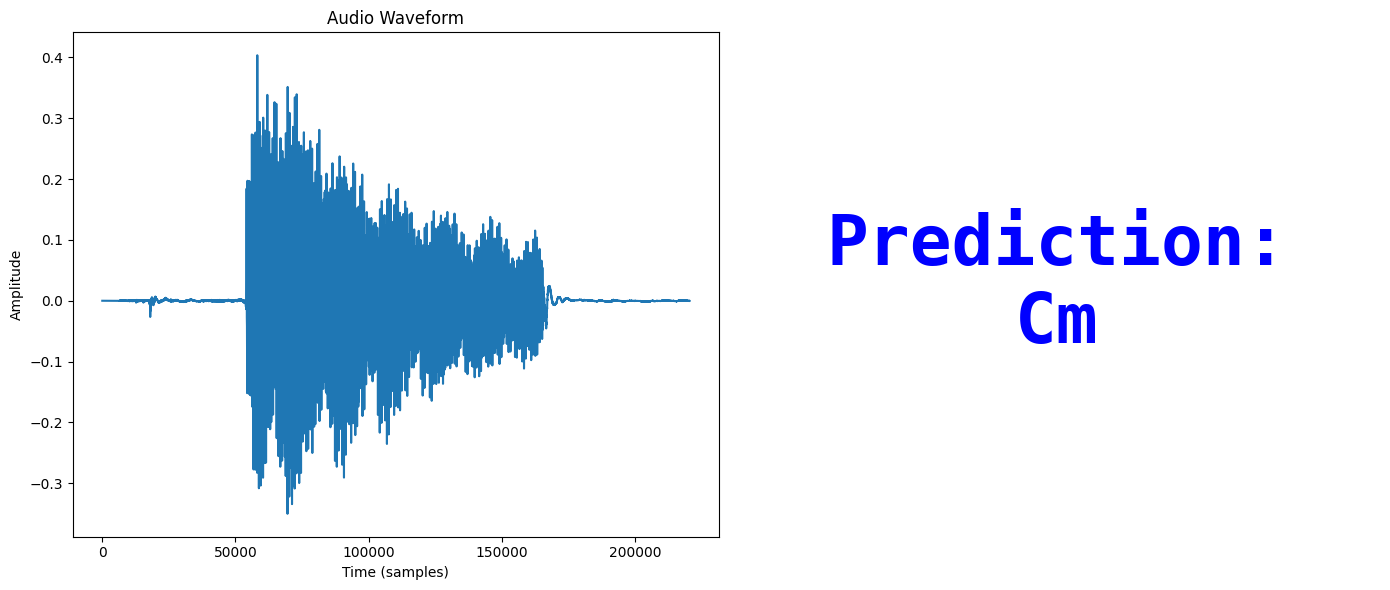

Audio saved to Guitar/Cm_1746874131.wav


In [7]:
# Record audio 
print("Recording...")

audio_data = sd.rec(int(sample_rate * duration),
                    samplerate=sample_rate,
                    channels=1,
                    dtype='float32',
                    device=device_index)

sd.wait()  # Wait for the recording to finish

clear_output(wait=True)
print("Recording finished.")

audio_data = audio_data.flatten()

chromagram = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
chromagram = (chromagram - np.mean(chromagram)) / (np.std(chromagram) + 1e-8)

torch_chroma = torch.tensor(np.array(chromagram), dtype=torch.float32)
torch_chroma = torch_chroma.unsqueeze(0).unsqueeze(0)
torch_chroma = torch_chroma.to(device)

C = librosa.cqt(audio_data, sr=sample_rate, hop_length=512, n_bins=84, bins_per_octave=12)
C = librosa.amplitude_to_db(abs(C))
C = (C - np.mean(C)) / (np.std(C) + 1e-8)

torch_cqt = torch.tensor(np.array(C), dtype=torch.float32)
torch_cqt = torch_cqt.unsqueeze(0).unsqueeze(0)
torch_cqt = torch_cqt.to(device)

with torch.no_grad():
    root_output = root_model(torch_chroma)
    predicted_root_label = torch.argmax(root_output, dim=1).item()

    chord_output = chord_model(torch_cqt)
    predicted_chord_label = torch.argmax(chord_output, dim=1).item()

root_label_mapping = {v: k for k, v in root_mapping.items()}
predicted_root = root_label_mapping[predicted_root_label]

chord_label_mapping = {v: k for k, v in chord_mapping.items()}
predicted_chord = chord_label_mapping[predicted_chord_label]


print("Root: "+ predicted_root)
print("Chord: " + predicted_chord)

# Rseult Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(audio_data)
ax1.set_title('Audio Waveform')
ax1.set_xlabel('Time (samples)')
ax1.set_ylabel('Amplitude')

ax2.text(0.5, 0.5, f'Prediction:\n{predicted_root}{predicted_chord}',
         fontsize=50, ha='center', va='center',
         color='blue', fontweight='bold', family='monospace')
ax2.axis('off')  # Optional: hide axes in the text plot

plt.tight_layout()  # Adjust spacing
plt.show()

user_label = input("Enter chord label:")

# Save audio 
dataset_dir = 'Guitar/'
# os.makedirs(dataset_dir, exist_ok=True)

filename = f"{user_label}_{int(time.time())}.wav"
filepath = os.path.join(dataset_dir, filename)
sf.write(filepath, audio_data, sample_rate)

print(f"Audio saved to {filepath}")
ipd.Audio(audio_data, rate=sample_rate)